### Modelling Covid-19 outbreak in Slovakia 
Miroslav Gasparek, 22 March 2020

This is an implementation of Dr Richard Kollar SIR model with migration within and outside municipalities
The code is vectorized to reduce the run time.

The model is a standard SIR with its shortcomings, although it might be satisfactory for the initial rough estimates. 


In [182]:
# Import the numerical module
import numpy as np

# Import the module for measuring code execution time
import timeit

# Import the plotting module
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('default')

In [183]:
### Parameters
tau = 2/3 # Proportion of time people interact at their home location
alpha = 1 # Mobility parameter
gamma = 0.1 # Inverse duration of infection 

### Vector of infection rates
beta_vec = np.array([0.5, 0.1, 0.3])

### Mobility matrix 
OD = np.array([[3,5,1], [20,3,5], [2,10,3]])

### Initial conditions
S = np.array([10,30,10])
I = np.array([5, 10, 5])
R = np.array([0,0,0])
N = np.array([15, 40, 15])

### Simulation parameters 
n = 150 # Number of days

### Initialization & Set-up
### Rescaling
x = I / N # Relative No. of susceptibles
y = S / N # Relative No, of infected

# Get the number of municipalities
S_rows = np.shape(S)[0]
I_rows = np.shape(I)[0]
R_rows = np.shape(R)[0]

x_rows = np.shape(x)[0]
y_rows = np.shape(y)[0]


### Pre-allocate the matrices 
S_mat = np.zeros((S_rows, n))
I_mat = np.zeros((I_rows, n))
R_mat = np.zeros((R_rows, n))

x_mat = np.zeros((x_rows, n))
y_mat = np.zeros((y_rows, n))

### Initialize the matrices
S_mat[:,0] = S
I_mat[:,0] = I
R_mat[:,0] = R

x_mat[:,0] = x
y_mat[:,0] = y


In [184]:
### Here we loop over to solve the difference equation
for i in range(n-1):
    
    # Define the term outside working hours that population at the given location interacts
    first_term = tau*(np.multiply(np.multiply(S_mat[:,i], I_mat[:,i]),beta_vec))/N
    
    # Define the second term that describes the interaction  of susceptible population
    # during the working hours at given location with those infected that travelled to that location
    second_term_1 = alpha*(1-tau)*(S_mat[:,i] - np.multiply(y_mat[:,i],(OD.sum(axis=0) - np.diag(OD)) ))
    second_term_2 = np.matmul(OD-np.diag(OD),(beta_vec*x_mat[:,i]) ) 
    second_term_3 = (I_mat[:,i] - x_mat[:,i]*(OD.sum(axis=0) - np.diag(OD)) ) * beta_vec
    second_term_den = N - (OD.sum(axis=0) - np.diag(OD)) + (OD.sum(axis=1) - np.diag(OD))
    
    second_term = (second_term_1*(second_term_2+second_term_3))/second_term_den
    
    # Define the third term that describes the interaction of susceptible population that travelled to
    # other location during the working hours, with ther infected at the working location
    third_term_1 = alpha*(1-tau)*y_mat[:,i]
    third_term_2 = np.matmul((OD.sum(axis=0) - np.diag(OD)), (second_term_2+second_term_3)/second_term_den)
    
    third_term = np.multiply(third_term_1, third_term_2)
    
    # Iterate over the Susceptible
    S_mat[:,i+1] = S_mat[:,i] - first_term - second_term - third_term
    
    # Iterate over the Infected
    I_mat[:,i+1] = I_mat[:,i] + first_term - gamma*I_mat[:,i] + second_term + third_term
    
    # Iterate over the Recovered
    R_mat[:,i+1] = R_mat[:,i] + gamma*I_mat[:,i]
    
    # Iterate over the normalized values
    x_mat[:,i+1] = I_mat[:,i+1]/N # Relative number of infected
    y_mat[:,i+1] = S_mat[:,i+1]/N # Relative number of suceptible

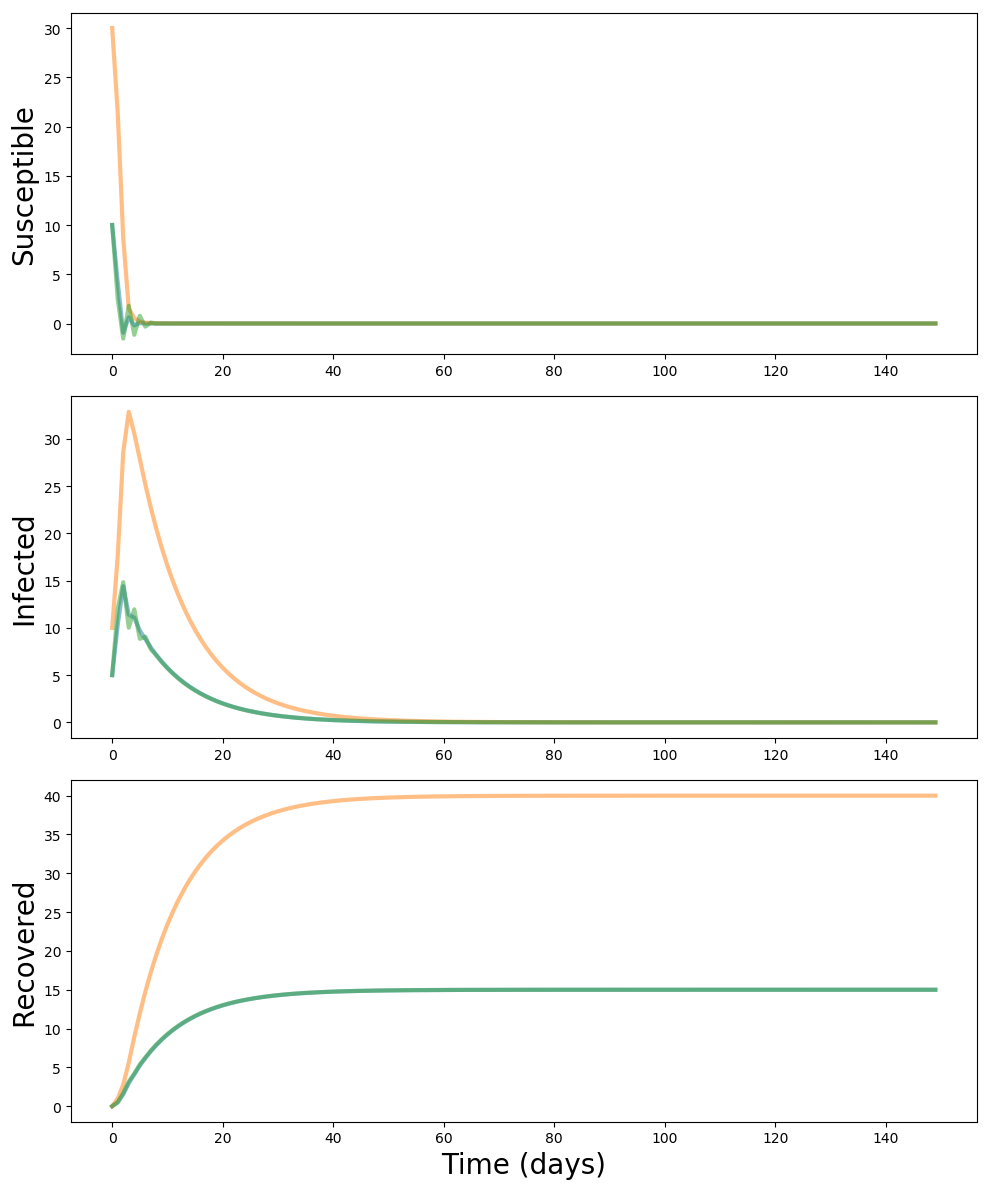

In [185]:
### Plotting the numbers of susceptible, infected, and recovered

# Create the time vector for plotting
t_vec = np.arange(n)

# Create a figure with three subplots
fig = plt.figure(figsize=(10,12))
fig.figsize = (5,10)

# Plot numbers of susceptible 
ax1 = plt.subplot(311)
for i in range(np.shape(S_mat)[0]):
    ax1.plot(t_vec, S_mat[i,:], LineWidth=3, alpha=0.5)
    ax1.set_ylabel('Susceptible',fontsize=20)
    
ax2 = plt.subplot(312)
for i in range(np.shape(I_mat)[0]):
    ax2.plot(t_vec, I_mat[i,:], LineWidth=3, alpha=0.5)
    ax2.set_ylabel('Infected',fontsize=20)
    
ax3 = plt.subplot(313)
for i in range(np.shape(R_mat)[0]):
    ax3.plot(t_vec, R_mat[i,:], LineWidth=3, alpha=0.5)
    ax3.set_ylabel('Recovered',fontsize=20)
    ax3.set_xlabel('Time (days)',fontsize=20)

plt.tight_layout()
plt.show()

## Main function for integration
The function below accepts all the parameters and initial conditions and solves numerically for the time evolution of all three states for each municipality.
**This is the function that you want to integrate into your main code**

In [186]:
def simulate_SIR_model_with_mobility(alpha, beta_vec, gamma, tau, OD,
                                     S_init, I_init, R_init, N,
                                     t_sim):
    """
    This function runs the simulation of the SIR model
    with migration within and outside municipality described by 
    the difference equations.
    -------
    Inputs: 
    - alpha (float in [0,1]): mobility parameter that describes
                              the movement of the population
    - beta_vec (nd.array): vector of infection rates for the population
                           at each municipality
    - gamma (float): scalar, reciprocal of the infectious period
    - tau (float in [0,1]): proportion of time that person spends at home location
    - OD (nd.array, m by m matrix): The matrix that describes the mobility of the population
    - S_init (nd. array, dtype=int): vector of initial number of Suceptible in each municipality
    - I_init (nd.array, dtype=int): vector of initial number of Infected in each municipality
    - R_init (nd.arraym dtype=int): vector of initial number of Recovered in each municipality
    - N (int): total population, sum N = S+I+R
    - t_sim (int): length of simulation in days
    ------                           
    Outputs:
    - S_mat (nd.array): Matrix with number of Susceptibles
                    at every municipality on each day,
                    row vector for each municipality

    - I_mat (nd.array): Matrix with number of Infected
                    at every municipality on each day,
                    row vector for each municipality.

    - R_mat (nd.array): Matrix with number of Recovered
                    at every municipality on each day,
                    row vector for each municipality.

    - t_vec (nd.array): Time vector of days.
    
    """
    
    ### Initialization & Set-up
    # Rescaling
    x = I / N # Relative No. of susceptibles
    y = S / N # Relative No. of infected

    # Get the number of municipalities
    S_rows = np.shape(S)[0]
    I_rows = np.shape(I)[0]
    R_rows = np.shape(R)[0]

    x_rows = np.shape(x)[0]
    y_rows = np.shape(y)[0]


    # Pre-allocate the matrices 
    S_mat = np.zeros((S_rows, n))
    I_mat = np.zeros((I_rows, n))
    R_mat = np.zeros((R_rows, n))

    x_mat = np.zeros((x_rows, n))
    y_mat = np.zeros((y_rows, n))

    # Initialize the matrices
    S_mat[:,0] = S
    I_mat[:,0] = I
    R_mat[:,0] = R

    x_mat[:,0] = x
    y_mat[:,0] = y
    
    # Create the time vector for plotting
    t_vec = np.arange(t_sim)
    
    ### Running the simulation
    #Here we loop over to solve the difference equation
    for i in range(t_sim-1):

        # Define the term outside working hours that population at the given location interacts
        first_term = tau*(np.multiply(np.multiply(S_mat[:,i], I_mat[:,i]),beta_vec))/N

        # Define the second term that describes the interaction  of susceptible population
        # during the working hours at given location with those infected that travelled to that location
        second_term_1 = alpha*(1-tau)*(S_mat[:,i] - np.multiply(y_mat[:,i],(OD.sum(axis=0) - np.diag(OD)) ))
        second_term_2 = np.matmul(OD-np.diag(OD),(beta_vec*x_mat[:,i]) ) 
        second_term_3 = (I_mat[:,i] - x_mat[:,i]*(OD.sum(axis=0) - np.diag(OD)) ) * beta_vec
        second_term_den = N - (OD.sum(axis=0) - np.diag(OD)) + (OD.sum(axis=1) - np.diag(OD))

        second_term = (second_term_1*(second_term_2+second_term_3))/second_term_den

        # Define the third term that describes the interaction of susceptible population that travelled to
        # other location during the working hours, with ther infected at the working location
        third_term_1 = alpha*(1-tau)*y_mat[:,i]
        third_term_2 = np.matmul((OD.sum(axis=0) - np.diag(OD)), (second_term_2+second_term_3)/second_term_den)

        third_term = np.multiply(third_term_1, third_term_2)

        # Iterate over the Susceptible
        S_mat[:,i+1] = S_mat[:,i] - first_term - second_term - third_term

        # Iterate over the Infected
        I_mat[:,i+1] = I_mat[:,i] + first_term - gamma*I_mat[:,i] + second_term + third_term

        # Iterate over the Recovered
        R_mat[:,i+1] = R_mat[:,i] + gamma*I_mat[:,i]

        # Iterate over the normalized values
        x_mat[:,i+1] = I_mat[:,i+1]/N # Relative number of infected
        y_mat[:,i+1] = S_mat[:,i+1]/N # Relative number of suceptible
        
    # Return results
    return S_mat, I_mat, R_mat, t_vec


In [187]:
def plotting_SIR_model_with_mobility(S_mat, I_mat, R_mat, t_vec):
    """
    Plotting the time course of SIR model with mobility.
    ------
    Inputs:
    - S_mat (nd.array): Matrix with number of Susceptibles
                        at every municipality on each day,
                        row vector for each municipality
                        
    - I_mat (nd.array): Matrix with number of Infected
                        at every municipality on each day,
                        row vector for each municipality.

    - R_mat (nd.array): Matrix with number of Recovered
                        at every municipality on each day,
                        row vector for each municipality.
                        
    - t_vec (nd.array): Time vector of days.
    ------
    Outputs: none
                        
    """
    
    # Create a figure with three subplots
    fig = plt.figure(figsize=(10,12))
    fig.figsize = (5,10)

    # Plot numbers of susceptible 
    ax1 = plt.subplot(311)
    for i in range(np.shape(S_mat)[0]):
        ax1.plot(t_vec, S_mat[i,:], LineWidth=3, alpha=0.5)
        ax1.set_ylabel('Susceptible',fontsize=20)

    ax2 = plt.subplot(312)
    for i in range(np.shape(I_mat)[0]):
        ax2.plot(t_vec, I_mat[i,:], LineWidth=3, alpha=0.5)
        ax2.set_ylabel('Infected',fontsize=20)

    ax3 = plt.subplot(313)
    for i in range(np.shape(R_mat)[0]):
        ax3.plot(t_vec, R_mat[i,:], LineWidth=3, alpha=0.5)
        ax3.set_ylabel('Recovered',fontsize=20)
        ax3.set_xlabel('Time (days)',fontsize=20)

    plt.tight_layout()
    plt.show()

## Changing parameters
Below, we slightly change the trial paramterers to get the more illustrative plots. 
As we can see, the system behaves as expected

In [194]:
%%time

### A trial run of the function
### Parameters
tau = 2/3 # Proportion of time people interact at their home location
alpha = 1 # Mobility parameter
gamma = 0.1 # Inverse duration of infection 

### Vector of infection rates
beta_vec = np.array([0.5, 0.1, 0.3])

### Mobility matrix 
OD = np.array([[3,5,1], [20,3,5], [2,10,3]])

### Initial conditions
S = np.array([25,30,10])
I = np.array([5, 10, 5])
R = np.array([0,0,0])
N = np.array([30, 40, 15])

### Simulation parameters 
n = 150 # Number of days

(S_mat, I_mat, R_mat, t_vec) = simulate_SIR_model_with_mobility(alpha, beta_vec, gamma, tau, OD,
                                     S, I, R, N,
                                     n)

CPU times: user 17.1 ms, sys: 2.18 ms, total: 19.3 ms
Wall time: 17.6 ms


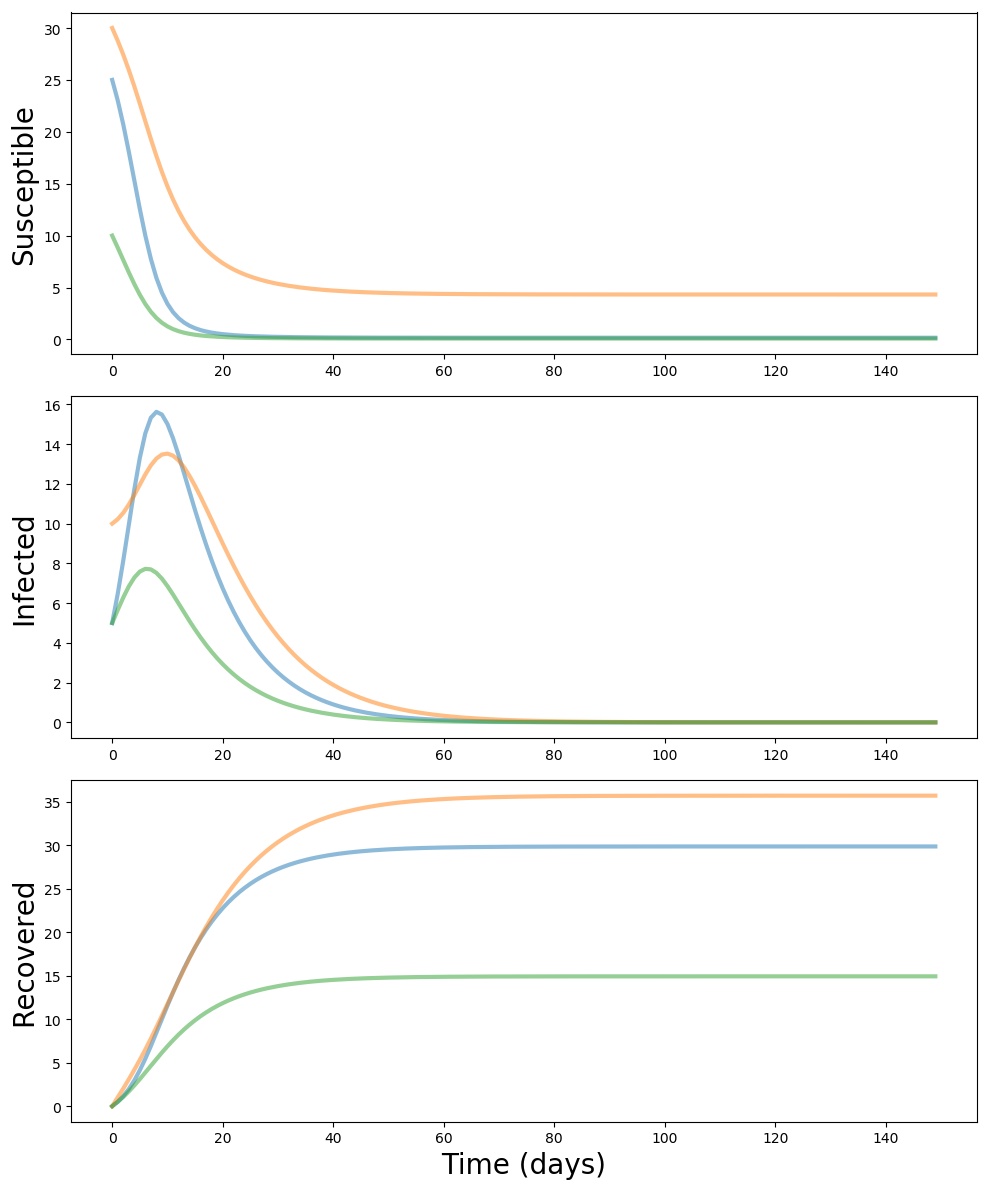

In [195]:
plotting_SIR_model_with_mobility(S_mat, I_mat, R_mat, t_vec)